## Семинар 2 "Распознавание рукописных цифр"

ФИО: Сабирьянов Артур

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
import numpy as np
import sys
from IPython.display import clear_output
from skimage.transform import rotate
from statistics import mode
from random import randint
import copy
import time
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [8]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
## Usage example:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

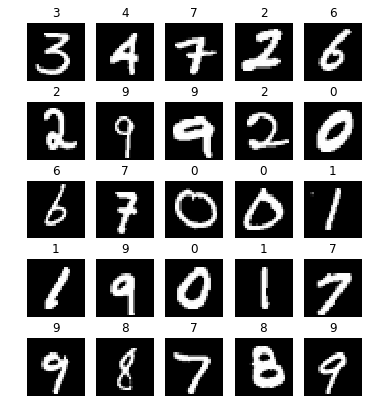

In [10]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [109]:
def train(network, epochs, learning_rate, trans = None, plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    Xg, yg = next(iter(train_loader))
    Xg = Xg.numpy()
    X_max = Xg.max()
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X_f, y in train_loader:
                X_f = X_f.view(X_f.shape[0], -1).numpy()
                y = y.numpy()
                X_f /= X_max
                X_mas = []   
                if(trans == "affine" or trans == "mixed"):
                    tt = []
                    for X_ in X_f:
                        tt += [copy.copy(X_.reshape(28, 28))]
                    X_mas += tt
                if(trans == "rotate" or trans == "mixed"):
                    for X_ in X_f:
                        tt = []
                        for j in range(-2, 3):
                            tmp = [rotate(X_.reshape(28, 28), 6 * j, mode='constant', cval = mode(X_.ravel()))]
                            tt += tmp
                        X_mas += tt
                if(trans == "noize" or trans == "mixed"):
                    ran = lambda : randint(0, 27)
                    
                    for X_ in X_f:
                        tt = []
                        for j in range(5):
                            hhm = copy.copy(X_.reshape(28, 28))
                            hhm[ran()][ran()] = 0.6
                            tt += [hhm]
                        X_mas += tt
                if(trans == None or trans == "mixed"):
                    tt = []
                    for X_ in X_f:
                        tt += [copy.copy(X_.reshape(28, 28))]
                    X_mas += tt
                X_mas = np.array(X_mas).reshape(-1, 32, 784)
                
                for X in X_mas:
                    #X = X.reshape(1, -1)
                    prediction = network.forward(X)
                    loss_batch = loss.forward(prediction, y)
                    losses.append(loss_batch)
                    dLdx = loss.backward()
                    network.backward(dLdx)
                    network.step(learning_rate)
                    accuracies.append((np.argmax(prediction, 1)==y).mean())
            
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [12]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.308/0.305	Accuracy: 0.919/0.920

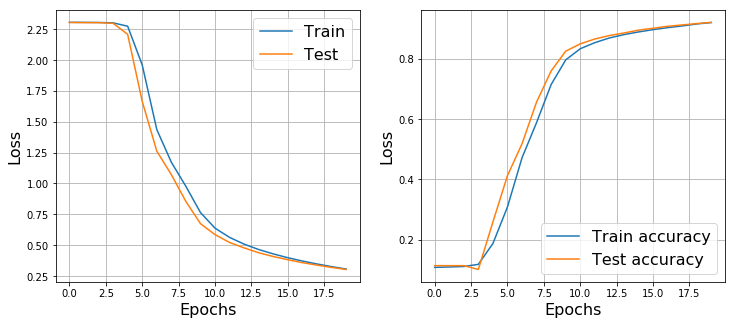

In [13]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [19]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = (self.X >= 0).astype(float)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [20]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [16]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=False, verbose=False)

In [17]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=False, verbose=False)

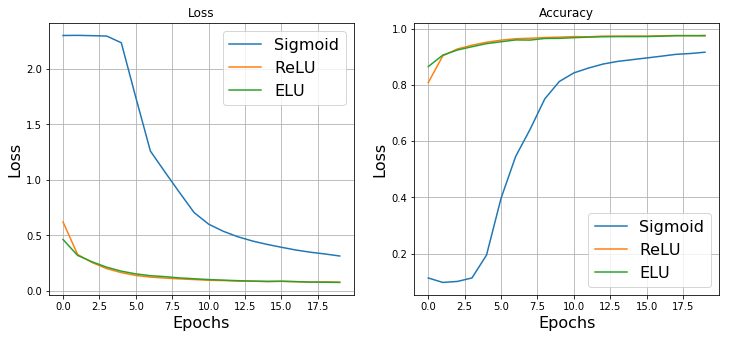

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [19]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

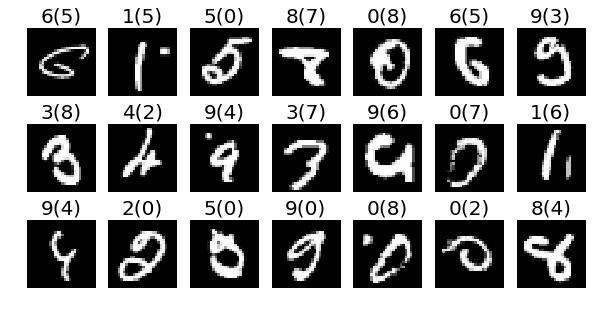

In [20]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### HW1 (1 балл): Реализовать Tanh

In [128]:
class Tanh:
    def __init__(self):
        pass
    def forward(self, X):
        self.a = np.exp(X)
        self.b = np.exp(-X)
        self.sh = (self.a - self.b) / 2
        self.ch = (self.a + self.b) / 2
        return self.sh / self.ch
    def backward(self, dLdy):
        return 1 / self.ch ** 2 * dLdy
    def step(self, learning_rate):
        pass

In [129]:
def check_gradient(func, X, gradient):
    numerical_gradient = np.zeros(X.shape)
    eps = 1e-5
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps
            y1 = func(X)
            X[i, j] -= 2*eps
            y2 = func(X)
            X[i, j] += eps
            numerical_gradient[i, j] = (y1-y2)/2/eps
    
    print (np.abs(numerical_gradient - gradient).max())

In [130]:
X = np.ones((5, 10))
s = Tanh()
def func(X):
    return s.forward(X).sum()

dLdy = np.ones((5, 10))
s.forward(X)
gradient = s.backward(dLdy)
check_gradient(func, X, gradient)

8.839540210914265e-11


### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [126]:
def sup(mode):
    if(mode == "affine"):
        transform = transforms.Compose([
                            transforms.RandomAffine(0, translate = (0.1, 0.1)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                        ])
    else:
        transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                        ])
    train_dataset = MNIST('.', train=True, download=True, transform=transform)
    test_dataset = MNIST('.', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
    loss = NLLLoss()
    tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 15, 0.025, trans = mode, plot=False, verbose=False)
    network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
    loss = NLLLoss()
    tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 15, 0.025, trans = mode, plot=False, verbose=False)
    network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
    loss = NLLLoss()
    tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 15, 0.025, trans = mode, plot=False, verbose=False)
    network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
    loss = NLLLoss()
    tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 15, 0.025, trans = mode, plot=False, verbose=False)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(ts_s, label='Sigmoid')
    plt.plot(ts_r, label='ReLU')
    plt.plot(ts_e, label='ELU')
    plt.plot(ts_t, label='Tahn')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(ts_ac_s, label='Sigmoid')
    plt.plot(ts_ac_r, label='ReLU')
    plt.plot(ts_ac_e, label='ELU')
    plt.plot(ts_ac_t, label='Tahn')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.show()

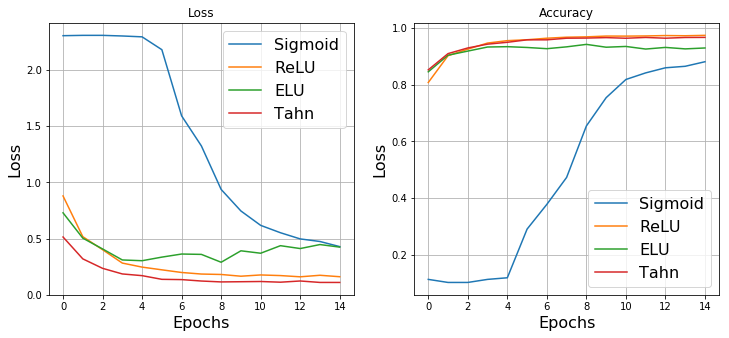

In [131]:
sup(None)

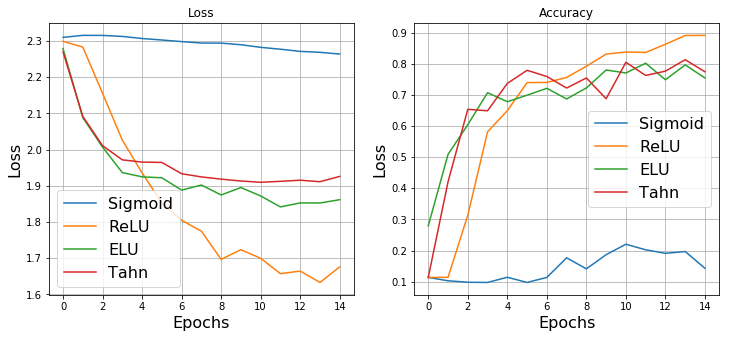

In [132]:
sup("rotate")

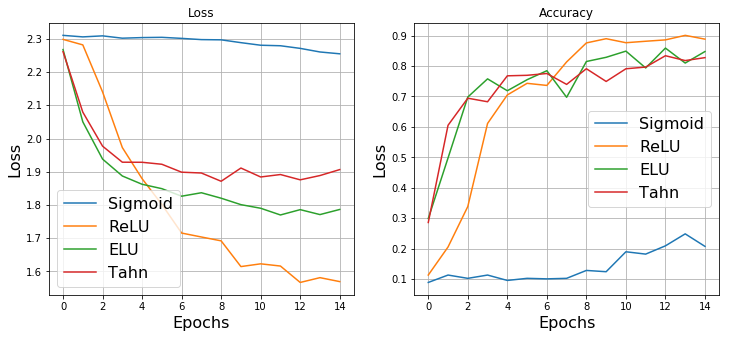

In [133]:
sup("noize")

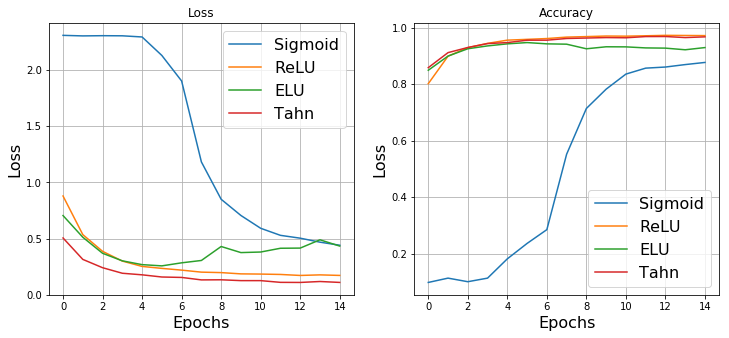

In [134]:
sup("affine")

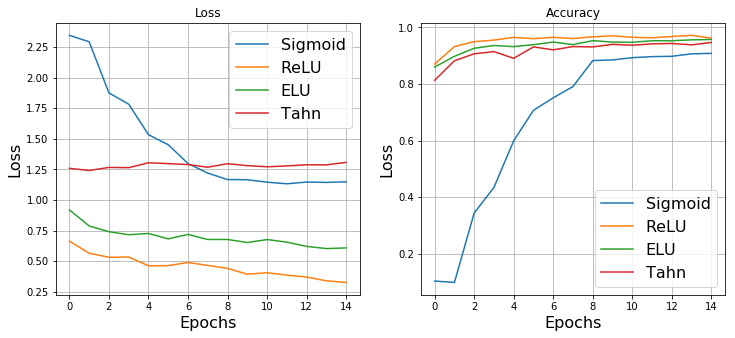

In [135]:
sup("mixed")

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

In [3]:
print("Все видно на графиках. Судя по ним ReLU выигрывает у остальных нелинейностей, а вот с сигмойдой совсем все плохо. Из аугментаций лучше всего себя показали сдвиги")

Все видно на графиках. Судя по ним ReLU выигрывает у остальных нелинейностей, а вот с сигмойдой совсем все плохо. Из аугментаций лучше всего себя показали сдвиги
